# Real Data: Hippocampal Place Cells on a Bandit Task

This notebook demonstrates neurospatial analysis with **real neural recording data**
from rat hippocampus during a spatial bandit task.

**Dataset**: J16 session from July 10, 2021
- 203 hippocampal units
- 709,321 position samples at 500 Hz (~24 minutes)
- Maze with 3 reward patches (bandit task)

**Estimated time**: 20-25 minutes

## Learning Objectives

By the end of this notebook, you will be able to:

- Load and preprocess real neural recording data
- Create a 1D linearized environment from a track graph
- Compute place fields from hippocampal spike data
- Analyze spatial coding with Skaggs information and sparsity
- Visualize place fields in both 2D and linearized 1D coordinates
- Understand trajectory-dependent analysis on complex mazes

In [ ]:
# Import the data loading function
import importlib.util
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from neurospatial import (
    Environment,
    HeadDirectionOverlay,
    PositionOverlay,
    compute_place_field,
)
from neurospatial.metrics import (
    detect_place_fields,
    field_centroid,
    field_size,
    skaggs_information,
    sparsity,
)

# Determine base path (works in both scripts and notebooks)
try:
    # When running as a script
    _base_path = Path(__file__).parent.parent
except NameError:
    # When running in Jupyter notebook
    _base_path = Path.cwd().parent if Path.cwd().name == "examples" else Path.cwd()

# Add data directory to path for imports
sys.path.insert(0, str(_base_path / "data"))
from load_bandit_data import load_neural_recording_from_files

# Configure matplotlib
plt.rcParams["figure.figsize"] = (14, 10)
plt.rcParams["font.size"] = 12

## Part 1: Load the Neural Recording Data

We load pre-processed data from a hippocampal recording session:
- Position tracking (head position, velocity, linear position)
- Spike times for 203 hippocampal units
- Track graph defining the maze structure

In [2]:
# Load the dataset
data_path = _base_path / "data"
data = load_neural_recording_from_files(data_path, "j1620210710_02_r1")

# Extract components
position_info = data["position_info"]
spike_times_all = data["spike_times"]
track_graph = data["track_graph"]
linear_edge_order = data["linear_edge_order"]
linear_edge_spacing = data["linear_edge_spacing"]

# Get basic info
n_units = len(spike_times_all)
n_samples = len(position_info)
duration = position_info.index[-1] - position_info.index[0]
sample_rate = n_samples / duration

print("=" * 60)
print("J16 BANDIT TASK - NEURAL RECORDING DATA")
print("=" * 60)
print(f"\nRecording duration: {duration:.1f} seconds ({duration / 60:.1f} minutes)")
print(f"Position samples: {n_samples:,} at {sample_rate:.0f} Hz")
print(f"Hippocampal units: {n_units}")
print(f"Total spikes: {sum(len(s) for s in spike_times_all):,}")

J16 BANDIT TASK - NEURAL RECORDING DATA

Recording duration: 1418.6 seconds (23.6 minutes)
Position samples: 709,321 at 500 Hz
Hippocampal units: 203
Total spikes: 870,018


### Examine Position Data

The position data includes 2D coordinates and pre-computed linear position:

In [3]:
print("\nPosition data columns:")
for col in position_info.columns:
    print(f"  - {col}")

print("\n2D position range:")
print(
    f"  X: [{position_info['head_position_x'].min():.1f}, {position_info['head_position_x'].max():.1f}] cm"
)
print(
    f"  Y: [{position_info['head_position_y'].min():.1f}, {position_info['head_position_y'].max():.1f}] cm"
)

print(
    f"\nLinear position range: [{position_info['linear_position'].min():.1f}, {position_info['linear_position'].max():.1f}] cm"
)
print(f"Track segments: {sorted(position_info['track_segment_id'].unique())}")
print(
    f"Reward patches: {sorted(position_info['patch_id'].dropna().unique().astype(int))}"
)


Position data columns:
  - head_position_x
  - head_position_y
  - head_orientation
  - head_velocity_x
  - head_velocity_y
  - head_speed
  - linear_position
  - track_segment_id
  - projected_x_position
  - projected_y_position
  - patch_id

2D position range:
  X: [30.1, 232.7] cm
  Y: [33.3, 222.9] cm

Linear position range: [0.3, 608.5] cm
Track segments: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
Reward patches: [np.int64(1), np.int64(2), np.int64(3)]


### Examine Track Graph

The maze is defined by a graph with 10 nodes (including arm endpoints,
junction nodes, and center):

In [4]:
print("\nTrack graph structure:")
print(f"  Nodes: {track_graph.number_of_nodes()}")
print(f"  Edges: {track_graph.number_of_edges()}")

print("\nNode positions:")
for node in sorted(track_graph.nodes()):
    pos = track_graph.nodes[node]["pos"]
    print(f"  Node {node}: ({pos[0]:.1f}, {pos[1]:.1f}) cm")

print("\nEdge order for linearization:")
for i, edge in enumerate(linear_edge_order):
    print(f"  {i}: {edge}")


Track graph structure:
  Nodes: 10
  Edges: 9

Node positions:
  Node 0: (179.5, 45.1) cm
  Node 1: (225.7, 123.3) cm
  Node 2: (184.2, 205.0) cm
  Node 3: (88.9, 209.7) cm
  Node 4: (37.9, 128.5) cm
  Node 5: (88.2, 45.1) cm
  Node 6: (179.6, 99.7) cm
  Node 7: (135.4, 180.5) cm
  Node 8: (87.5, 99.6) cm
  Node 9: (135.6, 127.3) cm

Edge order for linearization:
  0: (9, 6)
  1: (6, 0)
  2: (6, 1)
  3: (9, 7)
  4: (7, 2)
  5: (7, 3)
  6: (9, 8)
  7: (8, 4)
  8: (8, 5)


## Part 2: Visualize the Maze and Trajectory

Let's visualize the track structure and the animal's trajectory:

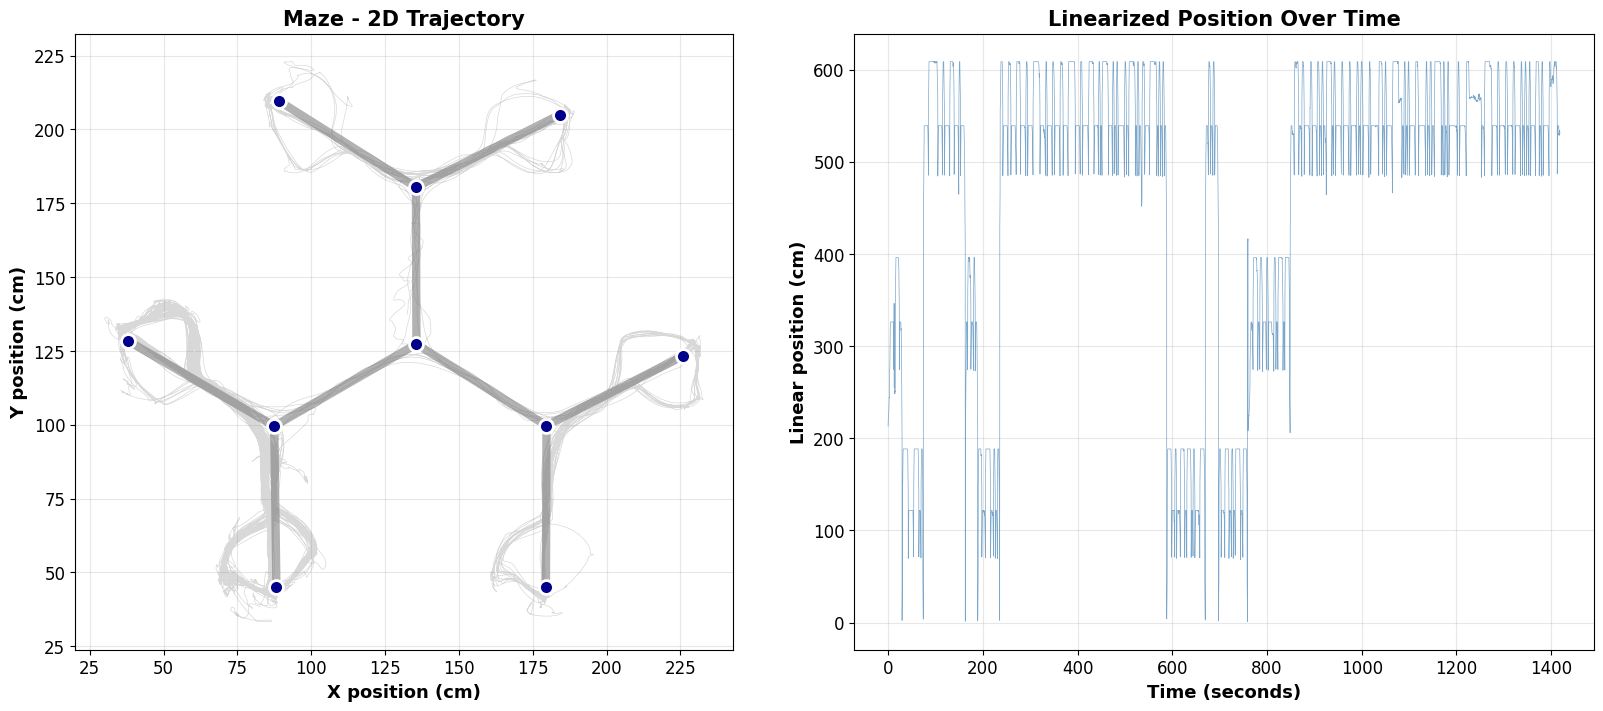


Trajectory covers the full maze with repeated visits to all arms


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7), constrained_layout=True)

# Left: 2D trajectory
ax = axes[0]
positions_2d = position_info[["head_position_x", "head_position_y"]].values

# Subsample for visualization
subsample = 20
ax.plot(
    positions_2d[::subsample, 0],
    positions_2d[::subsample, 1],
    "gray",
    alpha=0.3,
    linewidth=0.5,
    label="Trajectory",
)

# Draw track graph edges
for u, v in track_graph.edges():
    pos_u = np.array(track_graph.nodes[u]["pos"])
    pos_v = np.array(track_graph.nodes[v]["pos"])
    ax.plot(
        [pos_u[0], pos_v[0]],
        [pos_u[1], pos_v[1]],
        "k-",
        linewidth=6,
        alpha=0.3,
        zorder=1,
    )

# Mark nodes
for node in track_graph.nodes():
    pos = track_graph.nodes[node]["pos"]
    ax.scatter(
        pos[0], pos[1], s=100, c="darkblue", edgecolor="white", linewidth=2, zorder=10
    )
    ax.annotate(
        str(node),
        (pos[0], pos[1]),
        fontsize=10,
        ha="center",
        va="center",
        color="white",
        fontweight="bold",
    )

ax.set_xlabel("X position (cm)", fontsize=13, fontweight="bold")
ax.set_ylabel("Y position (cm)", fontsize=13, fontweight="bold")
ax.set_title("Maze - 2D Trajectory", fontsize=15, fontweight="bold")
ax.set_aspect("equal")
ax.grid(True, alpha=0.3)

# Right: Linear position over time
ax = axes[1]
times = position_info.index.values
linear_pos = position_info["linear_position"].values

# Use relative time (seconds from start)
times_relative = times - times[0]

ax.plot(
    times_relative[::subsample],
    linear_pos[::subsample],
    "steelblue",
    linewidth=0.5,
    alpha=0.7,
)
ax.set_xlabel("Time (seconds)", fontsize=13, fontweight="bold")
ax.set_ylabel("Linear position (cm)", fontsize=13, fontweight="bold")
ax.set_title("Linearized Position Over Time", fontsize=15, fontweight="bold")
ax.grid(True, alpha=0.3)

plt.show()

print("\nTrajectory covers the full maze with repeated visits to all arms")

## Part 3: Create Linearized Environment

We use `Environment.from_graph()` to create a 1D linearized representation
of the maze. This is essential for trajectory-dependent analysis.

In [6]:
# Create 1D linearized environment from track graph
env_1d = Environment.from_graph(
    graph=track_graph,
    edge_order=linear_edge_order,
    edge_spacing=linear_edge_spacing,
    bin_size=2.0,  # 2 cm bins for fine-grained analysis
    name="Maze_1D",
)
env_1d.units = "cm"

print("1D Linearized Environment Created!")
print(f"  Is 1D: {env_1d.is_1d}")
print(f"  Number of bins: {env_1d.n_bins}")
print(
    f"  Linear extent: [{env_1d.dimension_ranges[0][0]:.1f}, {env_1d.dimension_ranges[0][1]:.1f}] cm"
)

1D Linearized Environment Created!
  Is 1D: True
  Number of bins: 248
  Linear extent: [38.7, 224.8] cm


We can also create a 2D environment for comparison:

In [7]:
# Create 2D environment from position samples
env_2d = Environment.from_samples(
    positions_2d,
    bin_size=4.0,  # Slightly coarser for 2D to ensure good occupancy
    name="Maze_2D",
)
env_2d.units = "cm"

print("\n2D Environment Created!")
print(f"  Is 1D: {env_2d.is_1d}")
print(f"  Number of bins: {env_2d.n_bins}")
print(f"  Dimensions: {env_2d.n_dims}D")


2D Environment Created!
  Is 1D: False
  Number of bins: 557
  Dimensions: 2D


## Part 4: Examine Spike Data and Select Place Cells

Let's look at the spike count distribution to identify active neurons:

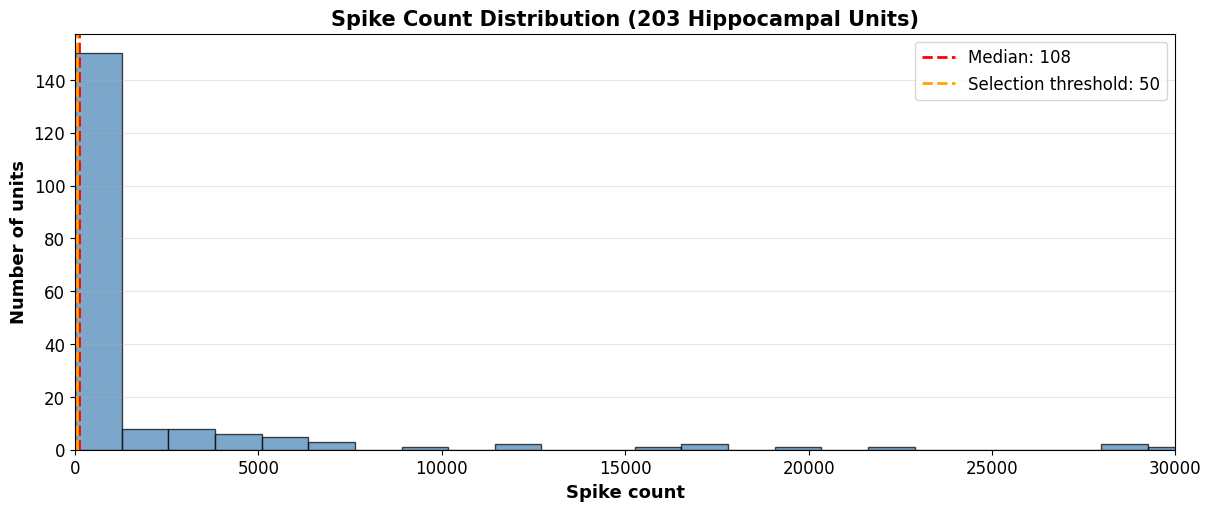


Units with >= 50 spikes: 108 / 203


In [8]:
# Count spikes for each unit
spike_counts = [len(s) for s in spike_times_all]

fig, ax = plt.subplots(figsize=(12, 5), constrained_layout=True)

ax.hist(spike_counts, bins=50, color="steelblue", edgecolor="black", alpha=0.7)
ax.axvline(
    np.median(spike_counts),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Median: {np.median(spike_counts):.0f}",
)
ax.axvline(
    50, color="orange", linestyle="--", linewidth=2, label="Selection threshold: 50"
)
ax.set_xlabel("Spike count", fontsize=13, fontweight="bold")
ax.set_ylabel("Number of units", fontsize=13, fontweight="bold")
ax.set_title(
    "Spike Count Distribution (203 Hippocampal Units)", fontsize=15, fontweight="bold"
)
ax.legend(fontsize=12)
ax.set_xlim(0, 30000)
ax.grid(True, alpha=0.3, axis="y")

plt.show()

# Select units with sufficient spikes for analysis
min_spikes = 50
active_units = [i for i, count in enumerate(spike_counts) if count >= min_spikes]
print(f"\nUnits with >= {min_spikes} spikes: {len(active_units)} / {n_units}")

## Part 5: Compute Place Fields for Selected Neurons

We'll compute place fields for several well-recorded neurons and analyze
their spatial coding properties.

In [ ]:
# Prepare trajectory data
times_array = position_info.index.values
positions_array = positions_2d

# Select a few example neurons with good spike counts
example_units = [i for i in active_units if 3000 <= spike_counts[i] <= 20000][:6]
print(f"Analyzing {len(example_units)} example units:")
for _i, unit_idx in enumerate(example_units):
    print(
        f"  Unit {unit_idx}: {spike_counts[unit_idx]:,} spikes ({spike_counts[unit_idx] / duration:.1f} Hz mean rate)"
    )

### Compute Place Fields

In [10]:
# Compute place fields for each example unit
place_fields = {}
spatial_metrics = {}

for unit_idx in example_units:
    spikes = spike_times_all[unit_idx]

    # Compute place field using diffusion KDE (boundary-aware)
    firing_rate = compute_place_field(
        env_2d,
        spikes,
        times_array,
        positions_array,
        smoothing_method="diffusion_kde",
        bandwidth=8.0,  # 8 cm smoothing
        min_occupancy_seconds=0.5,
    )

    place_fields[unit_idx] = firing_rate

    # Compute spatial metrics
    occupancy = env_2d.occupancy(times_array, positions_array, return_seconds=True)

    # Skaggs spatial information (bits/spike)
    info = skaggs_information(firing_rate, occupancy, base=2.0)

    # Sparsity
    sparse = sparsity(firing_rate, occupancy)

    # Mean firing rate
    mean_rate = len(spikes) / duration

    # Peak firing rate
    peak_rate = np.nanmax(firing_rate)

    spatial_metrics[unit_idx] = {
        "spatial_info": info,
        "sparsity": sparse,
        "mean_rate": mean_rate,
        "peak_rate": peak_rate,
    }

print("\nPlace fields computed for all example units")


Place fields computed for all example units


### Analyze Spatial Metrics

In [11]:
print("\n" + "=" * 70)
print("SPATIAL CODING METRICS")
print("=" * 70)
print(
    f"{'Unit':<8} {'Spikes':<10} {'Mean Rate':<12} {'Peak Rate':<12} {'Skaggs Info':<14} {'Sparsity':<10}"
)
print("-" * 70)

for unit_idx in example_units:
    m = spatial_metrics[unit_idx]
    print(
        f"{unit_idx:<8} {spike_counts[unit_idx]:<10} {m['mean_rate']:<12.2f} {m['peak_rate']:<12.2f} {m['spatial_info']:<14.3f} {m['sparsity']:<10.3f}"
    )

print("-" * 70)
print("\nInterpretation:")
print("  Skaggs Info > 1.0 bits/spike: Strong spatial coding")
print("  Sparsity > 0.3: Focal place field (fires in limited area)")


SPATIAL CODING METRICS
Unit     Spikes     Mean Rate    Peak Rate    Skaggs Info    Sparsity  
----------------------------------------------------------------------
0        4732       3.34         19.63        1.283          0.284     
9        11792      8.31         19.11        0.107          0.869     
10       15844      11.17        19.28        0.072          0.903     
14       6774       4.77         7.63         0.021          0.971     
15       9216       6.50         13.77        0.045          0.937     
25       5448       3.84         16.37        1.162          0.409     
----------------------------------------------------------------------

Interpretation:
  Skaggs Info > 1.0 bits/spike: Strong spatial coding
  Sparsity > 0.3: Focal place field (fires in limited area)


## Part 6: Visualize Place Fields

Let's visualize the place fields for our selected neurons:

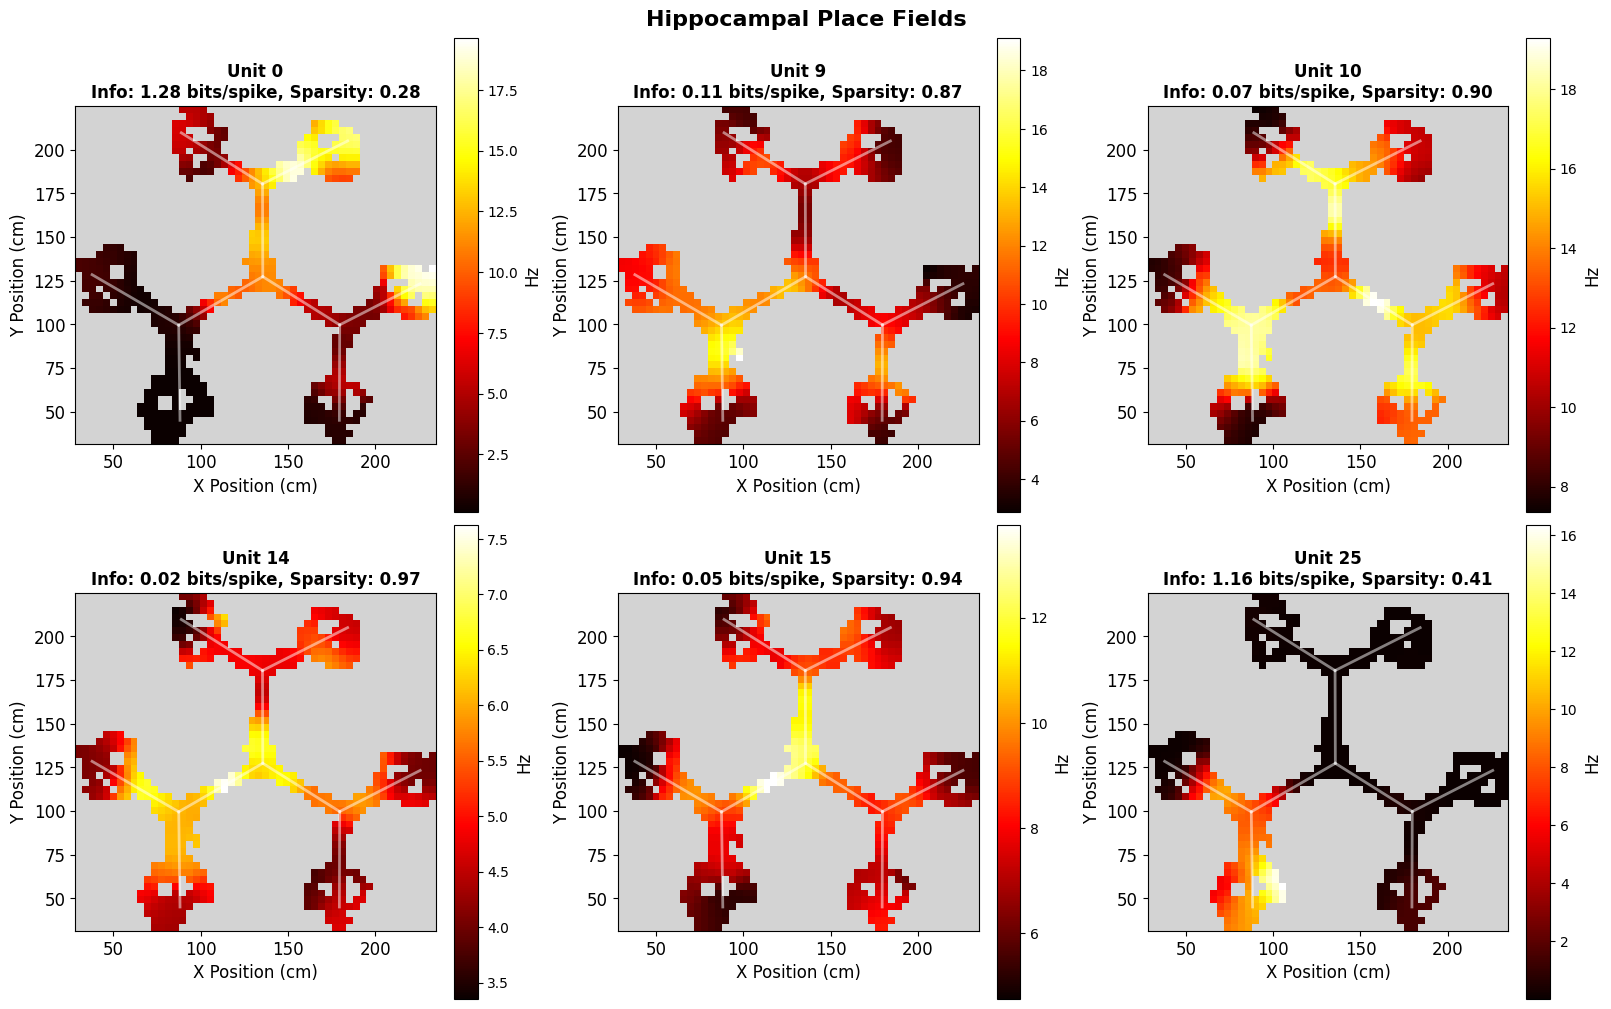

In [12]:
n_cols = 3
n_rows = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 10), constrained_layout=True)
axes = axes.flatten()

for i, unit_idx in enumerate(example_units):
    ax = axes[i]

    # Plot place field
    env_2d.plot_field(
        place_fields[unit_idx],
        ax=ax,
        cmap="hot",
        colorbar_label="Hz",
    )

    # Add track graph overlay
    for u, v in track_graph.edges():
        pos_u = np.array(track_graph.nodes[u]["pos"])
        pos_v = np.array(track_graph.nodes[v]["pos"])
        ax.plot(
            [pos_u[0], pos_v[0]],
            [pos_u[1], pos_v[1]],
            "w-",
            linewidth=2,
            alpha=0.5,
        )

    m = spatial_metrics[unit_idx]
    ax.set_title(
        f"Unit {unit_idx}\nInfo: {m['spatial_info']:.2f} bits/spike, Sparsity: {m['sparsity']:.2f}",
        fontsize=12,
        fontweight="bold",
    )
    ax.set_aspect("equal")

plt.suptitle("Hippocampal Place Fields", fontsize=16, fontweight="bold")
plt.show()

## Part 6b: Interactive Visualization with Napari

For interactive exploration, we can use napari to animate the animal's position
over the place field. This is especially useful for understanding how spatial
firing relates to the animal's trajectory.

**Note**: This section requires napari (`pip install napari[all]`). If napari
is not installed, this cell will be skipped.

In [ ]:
# Check if napari is available
NAPARI_AVAILABLE = importlib.util.find_spec("napari") is not None
if not NAPARI_AVAILABLE:
    print("Napari not installed. Skipping interactive visualization.")
    print("Install with: pip install napari[all]")

In [14]:
if NAPARI_AVAILABLE:
    # Select a cell with a clear place field for visualization
    best_unit = max(example_units, key=lambda u: spatial_metrics[u]["spatial_info"])
    best_field = place_fields[best_unit]

    print(f"Visualizing Unit {best_unit} in napari")
    print(
        f"  Spatial info: {spatial_metrics[best_unit]['spatial_info']:.2f} bits/spike"
    )

    # Subsample position data for smoother animation (500 Hz -> 30 fps)
    # Take every ~17th sample to get approximately 30 Hz
    subsample_rate = 17
    positions_subsampled = positions_array[::subsample_rate]
    times_subsampled = times_array[::subsample_rate]
    n_frames = len(positions_subsampled)

    # Tile static place field to match number of overlay frames
    # This displays a static field with the animated position overlay on top
    fields_animated = np.tile(best_field, (n_frames, 1))

    print("\nAnimation setup:")
    print(f"  Original samples: {len(positions_array):,}")
    print(
        f"  Subsampled to: {n_frames} frames (~{n_frames / 30:.1f} seconds at 30 fps)"
    )
    print(f"  Duration: {duration / 60:.1f} minutes")

    # Create position overlay with trail
    position_overlay = PositionOverlay(
        data=positions_subsampled,
        color="cyan",
        size=15.0,
        trail_length=15,  # Show last 15 positions as a trail
    )

    # Create head direction overlay if data is available
    overlays = [position_overlay]
    if "head_orientation" in position_info.columns:
        head_angles = position_info["head_orientation"].values[::subsample_rate]
        head_direction_overlay = HeadDirectionOverlay(
            data=head_angles,
            color="yellow",
            length=10.0,  # Arrow length in cm
            width=2.0,
        )
        overlays.append(head_direction_overlay)
        print("  Head direction: Available (yellow arrows)")
    else:
        print("  Head direction: Not available in this dataset")

    # Launch napari viewer with animation
    print("\nLaunching napari viewer...")
    print("  - Use the playback controls to animate")
    print("  - The cyan dot shows the animal's position")
    print("  - The trail shows recent movement history")

    env_2d.animate_fields(
        fields_animated,
        overlays=overlays,
        frame_times=times_subsampled,
        backend="napari",
        colormap="hot",
        title=f"Unit {best_unit} Place Field - Interactive",
    )

Visualizing Unit 0 in napari
  Spatial info: 1.28 bits/spike

Animation setup:
  Original samples: 709,321
  Subsampled to: 41725 frames (~1390.8 seconds at 30 fps)
  Duration: 23.6 minutes
  Head direction: Available (yellow arrows)

Launching napari viewer...
  - Use the playback controls to animate
  - The cyan dot shows the animal's position
  - The trail shows recent movement history


/Users/edeno/Documents/GitHub/neurospatial/src/neurospatial/animation/core.py:291: UserWarning: render_napari received unknown keyword arguments that will be ignored: bitrate, codec, colorbar_label, colormap, contrast_limits, dpi, dry_run, image_format, max_html_frames, n_workers, overlay_trajectory, show_colorbar. These may be parameters intended for other backends.
  return render_napari(


### Napari Features

The napari viewer provides:

- **Playback controls**: Play/pause, frame stepping, speed adjustment
- **Position overlay**: Cyan dot tracking the animal's location
- **Trail visualization**: Recent movement history shown as fading trail
- **Interactive exploration**: Zoom, pan, adjust contrast

For longer recordings, consider using video export:
```python
env_2d.animate_fields(
    fields, overlays=[position_overlay],
    backend="video", save_path="place_field_animation.mp4",
    fps=30, n_workers=4
)
```

## Part 7: Detect Place Fields Automatically

Use the `detect_place_fields()` function to identify place field bins
for each of our example neurons:

In [15]:
# Detect place fields for all example units
detected_fields_all = {}

for unit_idx in example_units:
    field = place_fields[unit_idx]

    # Detect place fields
    detected = detect_place_fields(
        field,
        env_2d,
        threshold=0.2,  # 20% of peak rate
        min_size=4,  # Minimum 4 bins
        detect_subfields=True,
    )

    detected_fields_all[unit_idx] = detected

    print(f"Unit {unit_idx}: {len(detected)} place field(s) detected")

Unit 0: 8 place field(s) detected
Unit 9: 4 place field(s) detected
Unit 10: 0 place field(s) detected
Unit 14: 3 place field(s) detected
Unit 15: 2 place field(s) detected
Unit 25: 1 place field(s) detected


### Visualize Detected Fields for Each Cell

Each cell gets its own figure showing the place field with detected regions
(left) and spike locations (right):

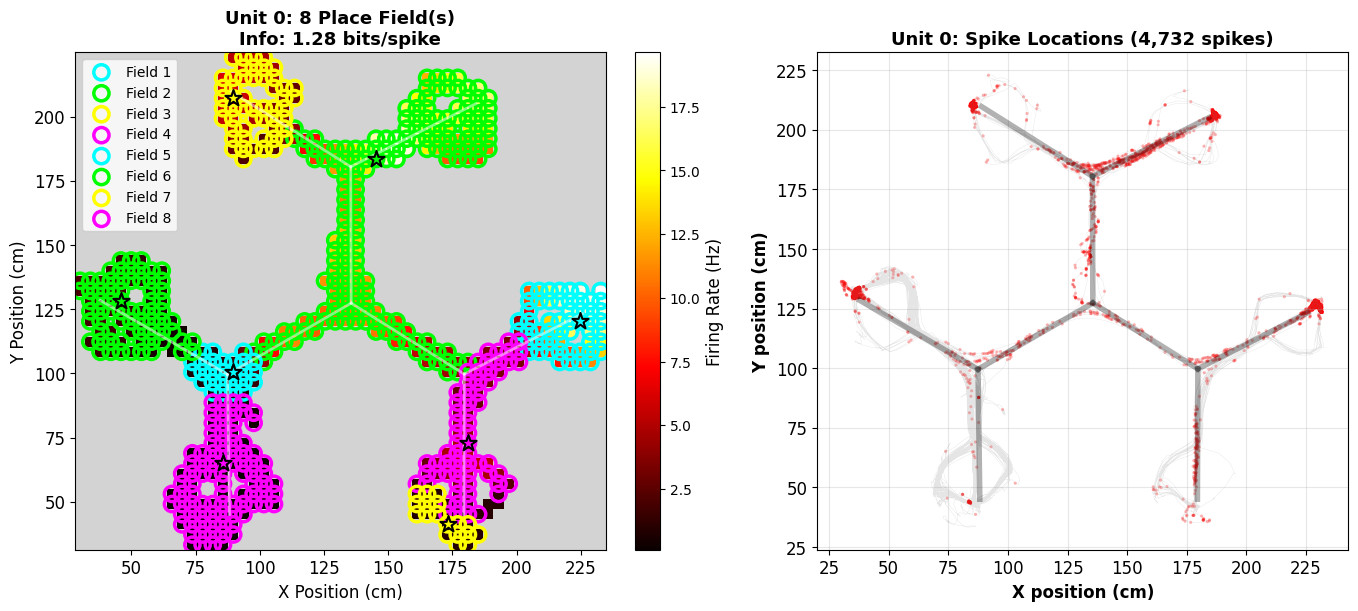

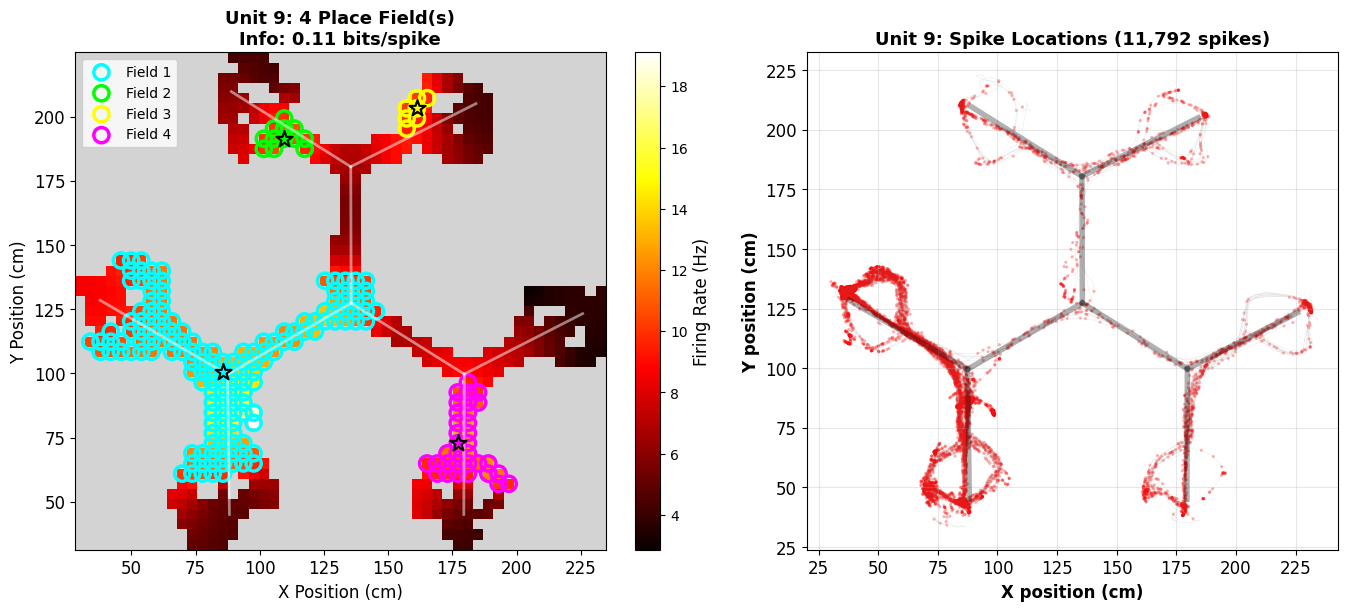

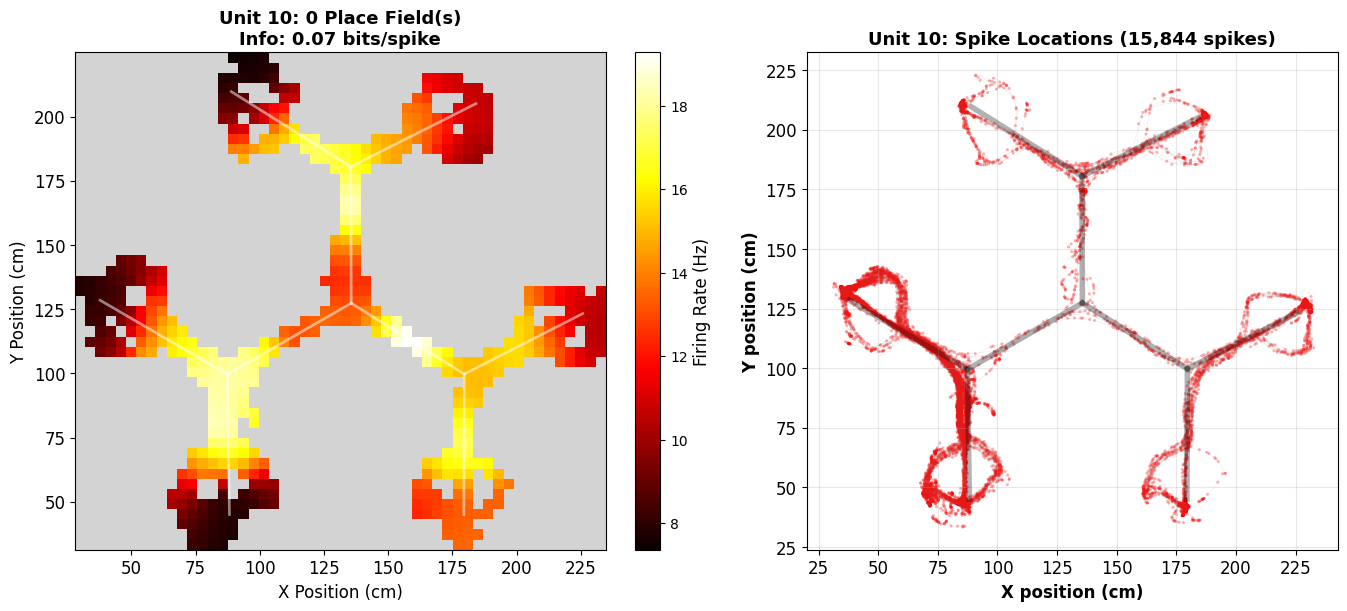

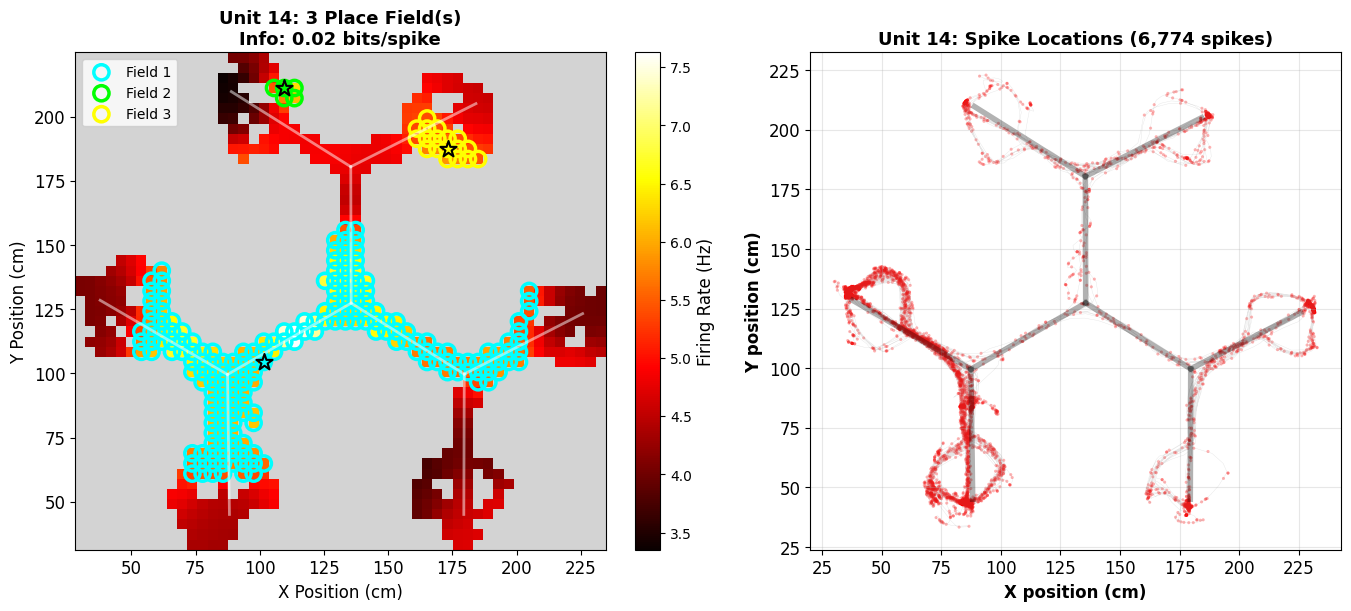

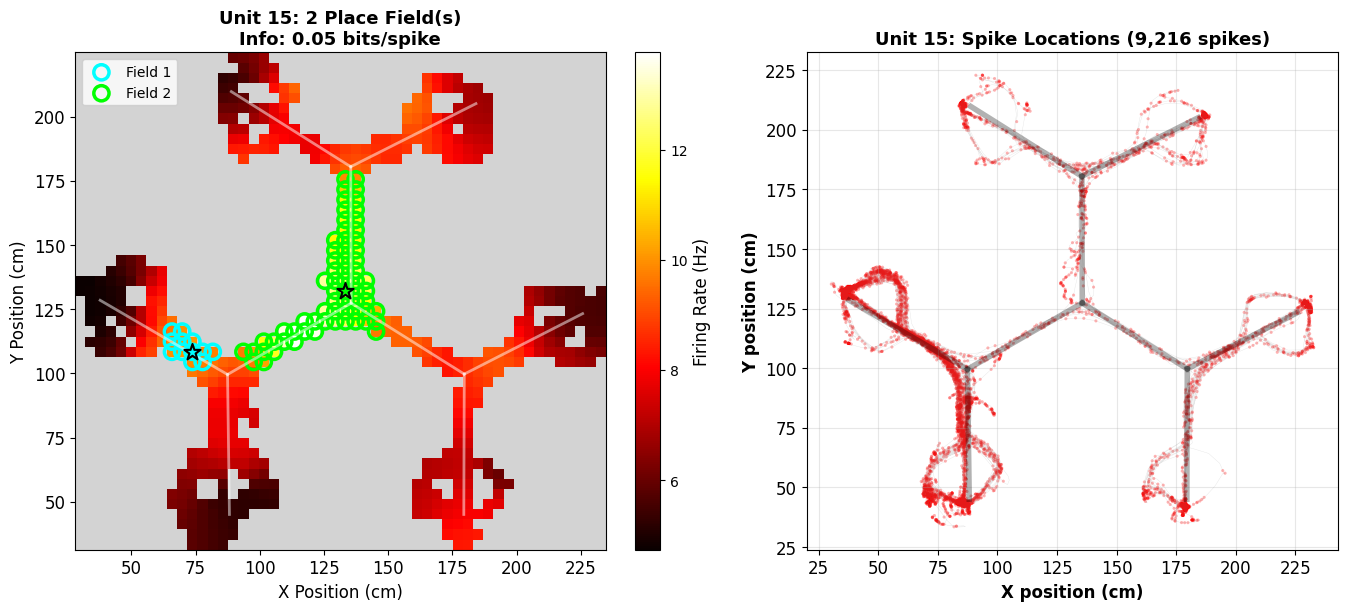

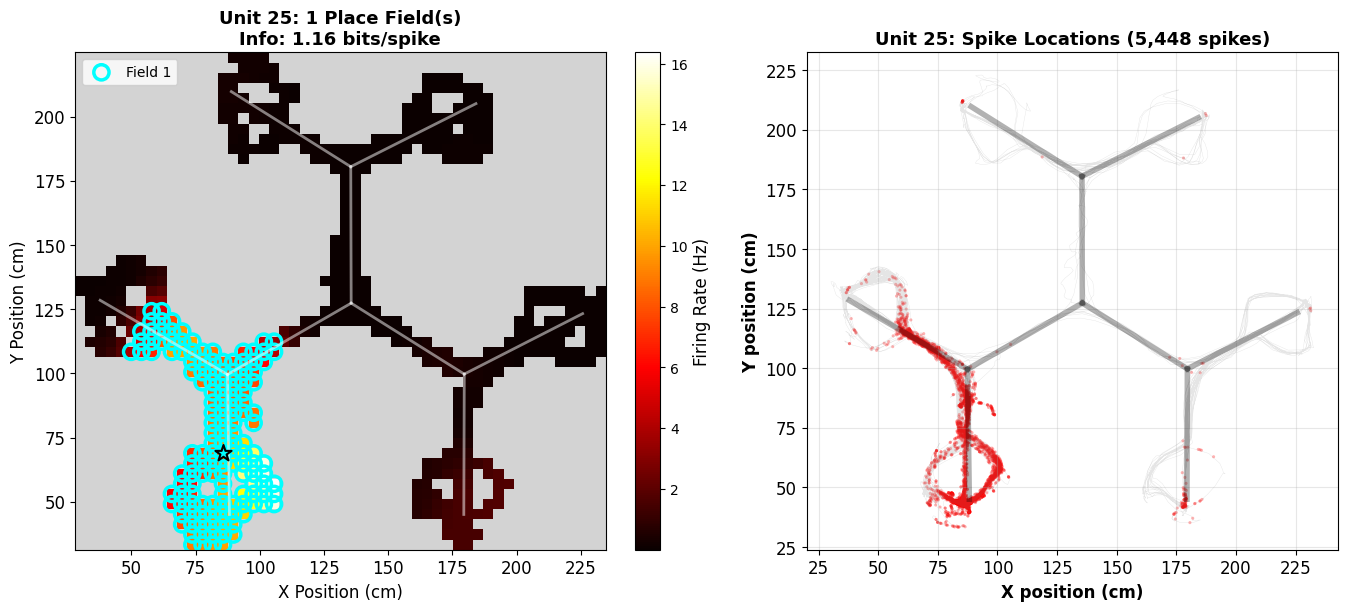

In [16]:
colors = ["cyan", "lime", "yellow", "magenta"]

for unit_idx in example_units:
    field = place_fields[unit_idx]
    detected_fields = detected_fields_all[unit_idx]
    m = spatial_metrics[unit_idx]

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

    # Left: Place field with detected regions highlighted
    ax = axes[0]
    env_2d.plot_field(
        field,
        ax=ax,
        cmap="hot",
        colorbar_label="Firing Rate (Hz)",
    )

    # Highlight detected field bins
    for i, field_bins in enumerate(detected_fields):
        ax.scatter(
            env_2d.bin_centers[field_bins, 0],
            env_2d.bin_centers[field_bins, 1],
            s=120,
            facecolors="none",
            edgecolors=colors[i % len(colors)],
            linewidths=2.5,
            label=f"Field {i + 1}",
        )

        # Mark centroid using graph-based method (respects maze geometry)
        centroid = field_centroid(field, field_bins, env_2d, method="graph")
        ax.scatter(
            centroid[0],
            centroid[1],
            s=150,
            c=colors[i % len(colors)],
            marker="*",
            edgecolors="black",
            linewidths=1.5,
            zorder=20,
        )

    # Add track overlay
    for u, v in track_graph.edges():
        pos_u = np.array(track_graph.nodes[u]["pos"])
        pos_v = np.array(track_graph.nodes[v]["pos"])
        ax.plot(
            [pos_u[0], pos_v[0]], [pos_u[1], pos_v[1]], "w-", linewidth=2, alpha=0.5
        )

    ax.set_title(
        f"Unit {unit_idx}: {len(detected_fields)} Place Field(s)\n"
        f"Info: {m['spatial_info']:.2f} bits/spike",
        fontsize=13,
        fontweight="bold",
    )
    if detected_fields:
        ax.legend(fontsize=10, loc="upper left")
    ax.set_aspect("equal")

    # Right: Spike locations
    ax = axes[1]

    # Plot trajectory
    ax.plot(
        positions_array[::50, 0],
        positions_array[::50, 1],
        "gray",
        alpha=0.2,
        linewidth=0.3,
    )

    # Plot spike locations
    spikes = spike_times_all[unit_idx]
    spike_positions = []
    for spike_time in spikes:
        idx = np.searchsorted(times_array, spike_time)
        if 0 <= idx < len(positions_array):
            spike_positions.append(positions_array[idx])

    spike_positions = np.array(spike_positions)
    ax.scatter(
        spike_positions[:, 0],
        spike_positions[:, 1],
        c="red",
        s=5,
        alpha=0.3,
        edgecolors="none",
    )

    # Add track overlay
    for u, v in track_graph.edges():
        pos_u = np.array(track_graph.nodes[u]["pos"])
        pos_v = np.array(track_graph.nodes[v]["pos"])
        ax.plot(
            [pos_u[0], pos_v[0]], [pos_u[1], pos_v[1]], "k-", linewidth=4, alpha=0.3
        )

    ax.set_xlabel("X position (cm)", fontsize=12, fontweight="bold")
    ax.set_ylabel("Y position (cm)", fontsize=12, fontweight="bold")
    ax.set_title(
        f"Unit {unit_idx}: Spike Locations ({len(spikes):,} spikes)",
        fontsize=13,
        fontweight="bold",
    )
    ax.set_aspect("equal")
    ax.grid(True, alpha=0.3)

    plt.show()

### Place Field Summary

In [17]:
# Print summary of detected place fields
print("\n" + "=" * 70)
print("PLACE FIELD DETECTION SUMMARY")
print("=" * 70)
print(
    f"{'Unit':<8} {'Fields':<10} {'Total Area':<15} {'Peak Rate':<12} {'Sparsity':<10}"
)
print("-" * 70)

for unit_idx in example_units:
    detected_fields = detected_fields_all[unit_idx]
    field = place_fields[unit_idx]
    m = spatial_metrics[unit_idx]

    # Calculate total field area
    total_area = sum(field_size(fb, env_2d) for fb in detected_fields)

    print(
        f"{unit_idx:<8} {len(detected_fields):<10} {total_area:<15.1f} "
        f"{m['peak_rate']:<12.1f} {m['sparsity']:<10.3f}"
    )

print("-" * 70)


PLACE FIELD DETECTION SUMMARY
Unit     Fields     Total Area      Peak Rate    Sparsity  
----------------------------------------------------------------------
0        8          8651.4          19.6         0.284     
9        4          3218.8          19.1         0.869     
10       0          0.0             19.3         0.903     
14       3          3375.8          7.6          0.971     
15       2          1224.7          13.8         0.937     
25       1          2276.7          16.4         0.409     
----------------------------------------------------------------------


## Part 8: Population Summary

Let's analyze spatial coding across all well-recorded neurons:

In [18]:
# Compute metrics for all active units
all_metrics = []

print("Computing spatial metrics for all active units...")
for unit_idx in active_units:
    spikes = spike_times_all[unit_idx]

    # Compute place field
    firing_rate = compute_place_field(
        env_2d,
        spikes,
        times_array,
        positions_array,
        smoothing_method="diffusion_kde",
        bandwidth=8.0,
        min_occupancy_seconds=0.5,
    )

    # Compute metrics
    occupancy = env_2d.occupancy(times_array, positions_array, return_seconds=True)
    info = skaggs_information(firing_rate, occupancy, base=2.0)
    sparse = sparsity(firing_rate, occupancy)
    mean_rate = len(spikes) / duration
    peak_rate = np.nanmax(firing_rate)

    all_metrics.append(
        {
            "unit": unit_idx,
            "spike_count": spike_counts[unit_idx],
            "mean_rate": mean_rate,
            "peak_rate": peak_rate,
            "spatial_info": info,
            "sparsity": sparse,
        }
    )

print(f"Analyzed {len(all_metrics)} units")

Computing spatial metrics for all active units...
Analyzed 108 units


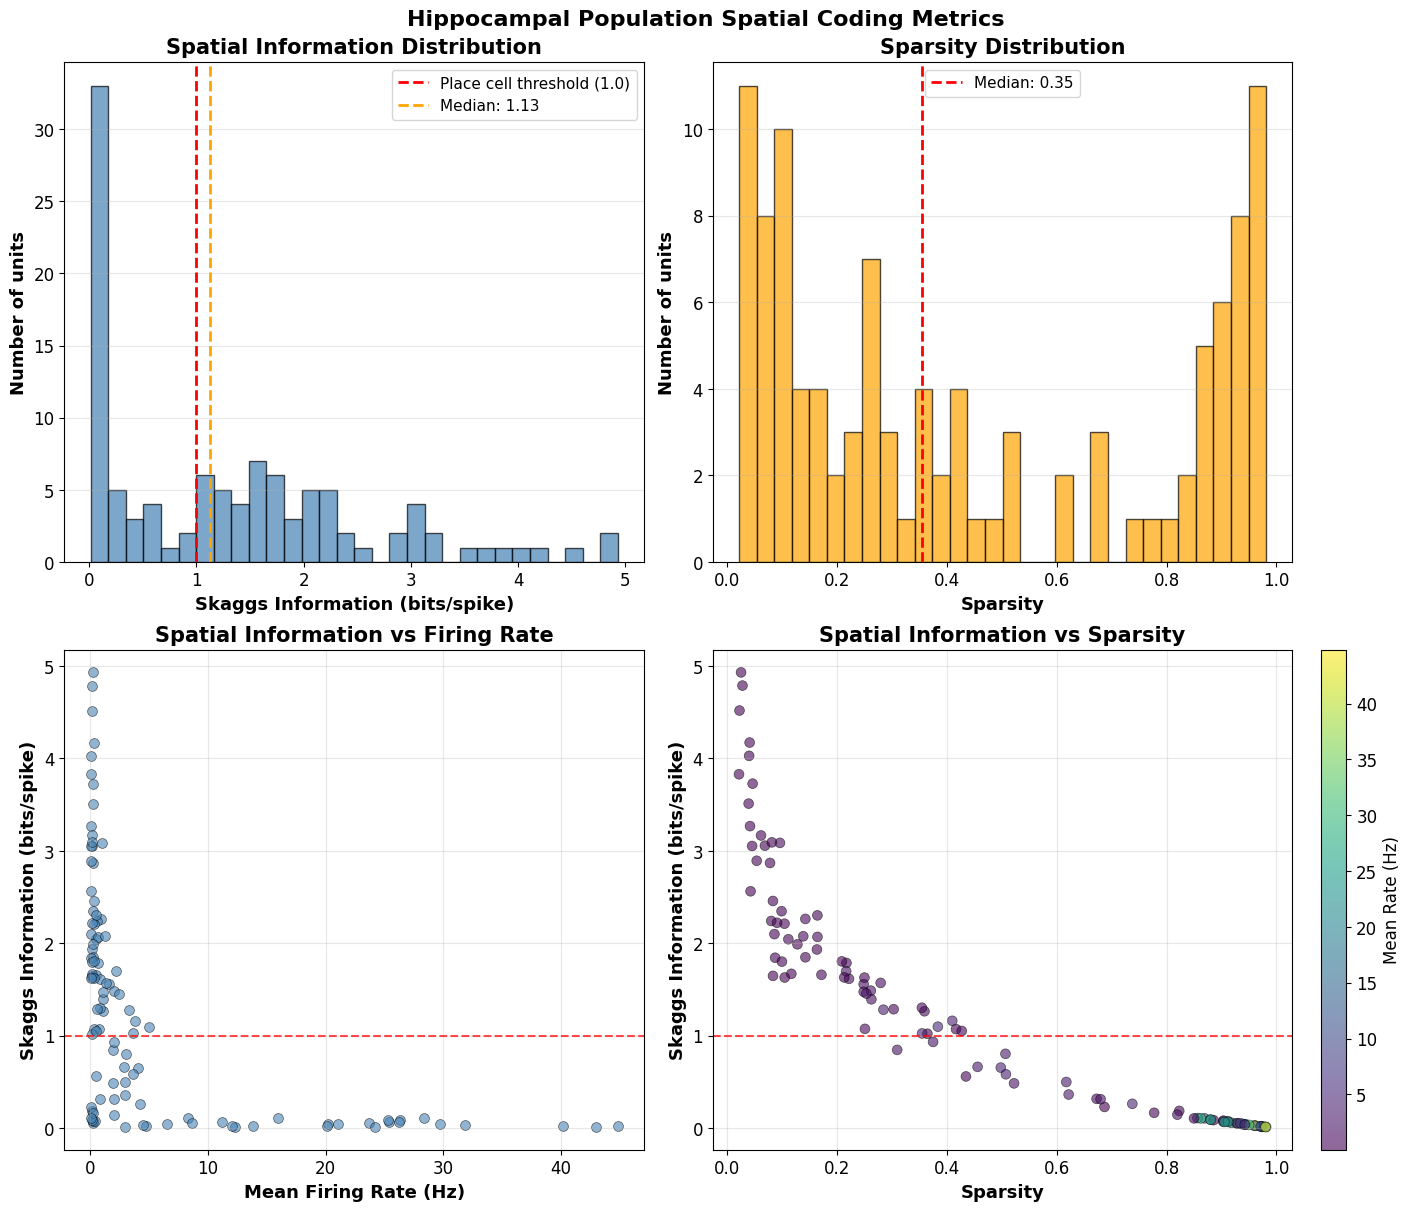


POPULATION SUMMARY

Total analyzed units: 108
Place cells (info > 1.0 bits/spike): 60 (55.6%)

Spatial Information:
  Mean: 1.319 bits/spike
  Median: 1.131 bits/spike
  Max: 4.931 bits/spike

Sparsity:
  Mean: 0.451
  Median: 0.354


_close_app() missing 1 required positional argument: 'window'
Traceback (most recent call last):
  File "/Users/edeno/Documents/GitHub/neurospatial/.venv/lib/python3.13/site-packages/in_n_out/_store.py", line 804, in _exec
    result = func(**bound.arguments)
TypeError: _close_app() missing 1 required positional argument: 'window'
Do not have argument for window: using providers [<function _provide_window at 0x2e4c194e0>]
Traceback (most recent call last):
  File "/Users/edeno/Documents/GitHub/neurospatial/.venv/lib/python3.13/site-packages/in_n_out/_store.py", line 804, in _exec
    result = func(**bound.arguments)
TypeError: _close_app() missing 1 required positional argument: 'window'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/edeno/Documents/GitHub/neurospatial/.venv/lib/python3.13/site-packages/app_model/backends/qt/_qaction.py", line 59, in _on_triggered
    self._app.commands.execute_command(self._comm

In [19]:
# Visualize population metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 12), constrained_layout=True)

# Extract metrics as arrays
spatial_info_all = np.array([m["spatial_info"] for m in all_metrics])
sparsity_all = np.array([m["sparsity"] for m in all_metrics])
mean_rate_all = np.array([m["mean_rate"] for m in all_metrics])
peak_rate_all = np.array([m["peak_rate"] for m in all_metrics])

# Top-left: Spatial information distribution
ax = axes[0, 0]
ax.hist(spatial_info_all, bins=30, color="steelblue", edgecolor="black", alpha=0.7)
ax.axvline(
    1.0, color="red", linestyle="--", linewidth=2, label="Place cell threshold (1.0)"
)
ax.axvline(
    np.median(spatial_info_all),
    color="orange",
    linestyle="--",
    linewidth=2,
    label=f"Median: {np.median(spatial_info_all):.2f}",
)
ax.set_xlabel("Skaggs Information (bits/spike)", fontsize=13, fontweight="bold")
ax.set_ylabel("Number of units", fontsize=13, fontweight="bold")
ax.set_title("Spatial Information Distribution", fontsize=15, fontweight="bold")
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis="y")

# Top-right: Sparsity distribution
ax = axes[0, 1]
ax.hist(sparsity_all, bins=30, color="orange", edgecolor="black", alpha=0.7)
ax.axvline(
    np.median(sparsity_all),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Median: {np.median(sparsity_all):.2f}",
)
ax.set_xlabel("Sparsity", fontsize=13, fontweight="bold")
ax.set_ylabel("Number of units", fontsize=13, fontweight="bold")
ax.set_title("Sparsity Distribution", fontsize=15, fontweight="bold")
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis="y")

# Bottom-left: Spatial info vs mean rate
ax = axes[1, 0]
ax.scatter(
    mean_rate_all,
    spatial_info_all,
    c="steelblue",
    s=50,
    alpha=0.6,
    edgecolors="black",
    linewidths=0.5,
)
ax.axhline(1.0, color="red", linestyle="--", linewidth=1.5, alpha=0.7)
ax.set_xlabel("Mean Firing Rate (Hz)", fontsize=13, fontweight="bold")
ax.set_ylabel("Skaggs Information (bits/spike)", fontsize=13, fontweight="bold")
ax.set_title("Spatial Information vs Firing Rate", fontsize=15, fontweight="bold")
ax.grid(True, alpha=0.3)

# Bottom-right: Spatial info vs sparsity
ax = axes[1, 1]
scatter = ax.scatter(
    sparsity_all,
    spatial_info_all,
    c=mean_rate_all,
    s=50,
    cmap="viridis",
    alpha=0.6,
    edgecolors="black",
    linewidths=0.5,
)
ax.axhline(1.0, color="red", linestyle="--", linewidth=1.5, alpha=0.7)
ax.set_xlabel("Sparsity", fontsize=13, fontweight="bold")
ax.set_ylabel("Skaggs Information (bits/spike)", fontsize=13, fontweight="bold")
ax.set_title("Spatial Information vs Sparsity", fontsize=15, fontweight="bold")
plt.colorbar(scatter, ax=ax, label="Mean Rate (Hz)")
ax.grid(True, alpha=0.3)

plt.suptitle(
    "Hippocampal Population Spatial Coding Metrics", fontsize=16, fontweight="bold"
)
plt.show()

# Summary statistics
n_place_cells = np.sum(spatial_info_all > 1.0)
print("\n" + "=" * 60)
print("POPULATION SUMMARY")
print("=" * 60)
print(f"\nTotal analyzed units: {len(all_metrics)}")
print(
    f"Place cells (info > 1.0 bits/spike): {n_place_cells} ({100 * n_place_cells / len(all_metrics):.1f}%)"
)
print("\nSpatial Information:")
print(f"  Mean: {np.mean(spatial_info_all):.3f} bits/spike")
print(f"  Median: {np.median(spatial_info_all):.3f} bits/spike")
print(f"  Max: {np.max(spatial_info_all):.3f} bits/spike")
print("\nSparsity:")
print(f"  Mean: {np.mean(sparsity_all):.3f}")
print(f"  Median: {np.median(sparsity_all):.3f}")

## Summary

In this notebook, we demonstrated neurospatial analysis with **real hippocampal
recording data** from a bandit task:

### Key Results

1. **Data Loading**: Successfully loaded neural data with 203 hippocampal units
   and 709,321 position samples

2. **Environment Creation**: Built both 2D and 1D linearized representations
   of the maze from a track graph

3. **Place Field Computation**: Used `compute_place_field()` with diffusion KDE
   for boundary-aware smoothing

4. **Interactive Visualization**: Used napari to animate position overlays on
   place fields for interactive exploration

5. **Spatial Metrics**: Computed Skaggs information and sparsity for population
   analysis

6. **Place Field Detection**: Automatically identified place fields with
   `detect_place_fields()`

### Key Functions Used

- `Environment.from_graph()` - Create 1D linearized environment
- `Environment.from_samples()` - Create 2D spatial environment
- `compute_place_field()` - Convert spikes to firing rate maps
- `env.animate_fields()` - Interactive napari visualization
- `PositionOverlay` - Animate animal position with trail
- `skaggs_information()` - Measure spatial information (bits/spike)
- `sparsity()` - Measure firing field compactness
- `detect_place_fields()` - Automatic place field detection
- `field_size()`, `field_centroid()` - Place field properties

### Next Steps

- Use linearized environment for trajectory-dependent analysis
- Segment trials and analyze behavior
- Compare place field stability across sessions
- Analyze population dynamics during decision-making

### References

- O'Keefe & Dostrovsky (1971): Discovery of place cells
- Skaggs et al. (1993): Spatial information metric
- Frank et al. (2000): Trajectory-dependent spatial coding